# Eksperimen BERT untuk Klasifikasi Emosi Ekman
## 6 Model Binary Classification vs Baseline Multi-class (WITH CLASS WEIGHTS)

**Tujuan Eksperimen:**
1. Melatih 6 model BERT terpisah (satu per emosi Ekman)
2. Setiap model melakukan binary classification (emotion vs non-emotion)
3. Membandingkan performa dengan baseline multi-class BERT
4. **MENANGANI CLASS IMBALANCE DENGAN CLASS WEIGHTS (BUKAN DATA MANIPULATION)**

**Arsitektur Model:**
- BERT base-uncased (Pre-trained dari HuggingFace)
- 12 layer transformer
- 12 attention heads
- Hidden size 768
- Total parameters: ~110 juta

**Hyperparameter (Fixed - No Tuning):**
- Learning rate: 2e-5
- Batch size: 32
- Epochs: 50
- Optimizer: AdamW dengan weight decay 0.01
- Mixed Precision: FP16 (untuk efisiensi memori & kecepatan)

**Metode Handling Class Imbalance:**
- **Strategi**: Class-Weighted Loss Function
- **Implementasi**: Weighted CrossEntropyLoss
- **Class Weights**: Computed using sklearn's 'balanced' strategy
  - Formula: `weight = n_samples / (n_classes * n_samples_per_class)`
- **Efek**: Minority class mendapat weight lebih tinggi (penalty lebih besar untuk error)
- **Keuntungan**:
  - ✅ Data asli tetap utuh (100% data retention)
  - ✅ Tidak ada synthetic samples
  - ✅ Komputasi lebih efisien
  - ✅ Implementasi sederhana
  - ✅ Teoritis sound

**Dataset (Original - NO Resampling):**
- Training: train.tsv (~43,000 samples, imbalanced)
- Development: dev.tsv (~5,400 samples)
- Testing: test.tsv (~5,400 samples)
- **PENTING**: Dataset TIDAK dimanipulasi (tidak ada SMOTE/downsampling)

**Emosi Ekman (6 Target + Neutral):**
- 😠 Anger
- 🤢 Disgust
- 😨 Fear
- 😊 Joy
- 😢 Sadness
- 😮 Surprise
- 😐 Neutral (excluded dari 6 binary models)

**Perbedaan dengan Notebook Lain:**
- **SMOTE Notebook**: Menggunakan synthetic oversampling untuk balance dataset
- **Downsampling Notebook**: Mengurangi majority class samples
- **Notebook INI**: Menggunakan weighted loss, data tetap original


In [ ]:
# Setup: Install dependencies dan import libraries
import sys
import subprocess

# Install required packages
packages = [
    'transformers',
    'torch',
    'scikit-learn',
    'pandas',
    'numpy',
    'matplotlib',
    'seaborn',
    'graphviz',
    'nltk',
    'Sastrawi',
    'contractions',
    'clean-text'
]

print("Installing required packages...")
for package in packages:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", package])

print("✓ All packages installed successfully!")

# Import libraries
import pandas as pd
import numpy as np
import json
import os
import warnings
import re
from collections import Counter
from datetime import datetime

import torch
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    BertTokenizer,
    BertForSequenceClassification,
    get_linear_schedule_with_warmup
)

from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve
)
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import matplotlib.pyplot as plt
import seaborn as sns

# NLTK for stopwords and tokenization
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Sastrawi for Indonesian stemming
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

# Text Preprocessing Libraries
import contractions
from cleantext import clean

warnings.filterwarnings('ignore')

# Download NLTK data
print("\nDownloading NLTK data...")
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('punkt_tab', quiet=True)
print("✓ NLTK data downloaded")

# Setup device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\nUsing device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.2f} GB")

# Create results directory
os.makedirs('results', exist_ok=True)
print("✓ Results directory created")

Installing required packages...
✓ All packages installed successfully!

✓ NLTK data downloaded

Using device: cuda
GPU: NVIDIA GeForce RTX 4070 SUPER
GPU Memory: 12.88 GB
✓ Results directory created


STEP 1: LOADING DATA & EKMAN MAPPING
✓ Loaded 28 original emotions
✓ Mapped to 7 Ekman categories
  Ekman emotions: ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

Loading datasets...
✓ Train set: 43,410 samples
✓ Dev set: 5,426 samples
✓ Test set: 5,427 samples

Ekman emotion distribution in training set:
  anger     : 5,316 (12.25%)
  disgust   :   579 ( 1.33%)
  fear      :   618 ( 1.42%)
  joy       : 16,941 (39.03%)
  sadness   : 2,648 ( 6.10%)
  surprise  : 4,485 (10.33%)
  neutral   : 12,823 (29.54%)


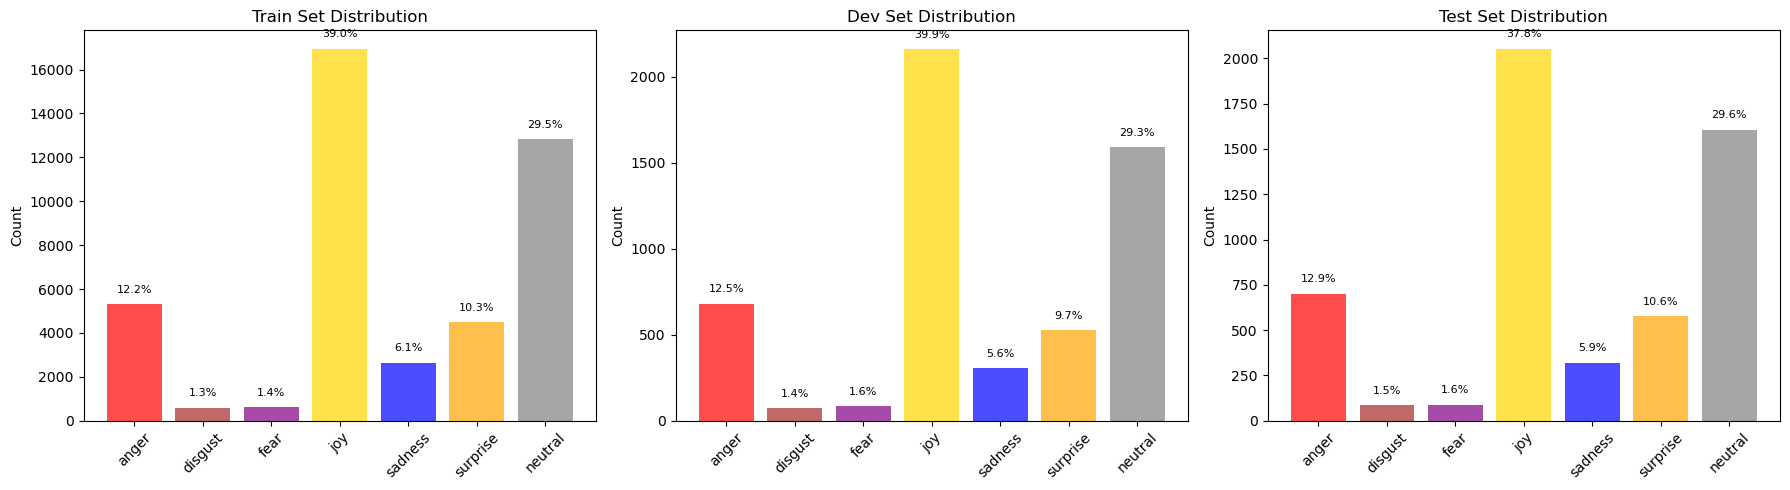


✓ Distribution plot saved t results/original_distribution.ng


In [3]:
# Step 1: Load Data dan Mapping ke Ekman Emotions
print("="*60)
print("STEP 1: LOADING DATA & EKMAN MAPPING")
print("="*60)

# Path ke data (sesuaikan dengan struktur folder Anda)
DATA_PATH = r'../data/'

# Load emotion mappings
with open(f'{DATA_PATH}emotions.txt', 'r', encoding='utf-8') as f:
    emotions = [line.strip() for line in f]

with open(f'{DATA_PATH}ekman_mapping.json', 'r', encoding='utf-8') as f:
    ekman_mapping = json.load(f)

# Create reverse mapping
idx_to_emotion = {i: emotion for i, emotion in enumerate(emotions)}
emotion_to_ekman = {}
for ekman_cat, emotion_list in ekman_mapping.items():
    for emotion in emotion_list:
        emotion_to_ekman[emotion] = ekman_cat
emotion_to_ekman['neutral'] = 'neutral'

print(f"✓ Loaded {len(emotions)} original emotions")
print(f"✓ Mapped to {len(set(emotion_to_ekman.values()))} Ekman categories")
print(f"  Ekman emotions: {sorted(set(emotion_to_ekman.values()))}")

def map_labels_to_ekman(label_str):
    """Map original labels to Ekman emotions with multi-label handling"""
    if ',' in str(label_str):
        # Multi-label: majority vote
        indices = [int(x) for x in str(label_str).split(',')]
        ekman_labels = [emotion_to_ekman.get(idx_to_emotion[idx], 'unknown') for idx in indices]
        counter = Counter(ekman_labels)
        return counter.most_common(1)[0][0]
    else:
        # Single label
        idx = int(label_str)
        emotion = idx_to_emotion[idx]
        return emotion_to_ekman.get(emotion, 'unknown')

def load_data(path):
    """Load TSV data and map to Ekman emotions"""
    df = pd.read_csv(path, sep='\t', header=None, names=['text', 'labels', 'id'])
    df['ekman'] = df['labels'].apply(map_labels_to_ekman)
    return df

# Load datasets
print("\nLoading datasets...")
train_df = load_data(f'{DATA_PATH}train.tsv')
dev_df = load_data(f'{DATA_PATH}dev.tsv')
test_df = load_data(f'{DATA_PATH}test.tsv')

print(f"✓ Train set: {len(train_df):,} samples")
print(f"✓ Dev set: {len(dev_df):,} samples")
print(f"✓ Test set: {len(test_df):,} samples")

# Display distribution
ekman_categories = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise', 'neutral']
print("\nEkman emotion distribution in training set:")
train_dist = train_df['ekman'].value_counts()
for emotion in ekman_categories:
    count = train_dist.get(emotion, 0)
    pct = (count / len(train_df)) * 100
    print(f"  {emotion:10s}: {count:5,} ({pct:5.2f}%)")

# Visualize distribution
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
colors = ['red', 'brown', 'purple', 'gold', 'blue', 'orange', 'gray']

for i, (name, df) in enumerate([('Train', train_df), ('Dev', dev_df), ('Test', test_df)]):
    counts = df['ekman'].value_counts().reindex(ekman_categories, fill_value=0)
    axes[i].bar(ekman_categories, counts, color=colors, alpha=0.7)
    axes[i].set_title(f'{name} Set Distribution')
    axes[i].set_ylabel('Count')
    axes[i].tick_params(axis='x', rotation=45)

    # Add percentage labels
    total = len(df)
    for j, count in enumerate(counts):
        if count > 0:
            pct = (count / total) * 100
            axes[i].text(j, count + total*0.01, f'{pct:.1f}%',
                        ha='center', va='bottom', fontsize=8)

plt.tight_layout()
plt.savefig('results/original_distribution.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Distribution plot saved t results/original_distribution.ng")

STEP 1.5: TEXT PREPROCESSING PIPELINE
Pipeline: Case Folding → Cleaning → Normalization → Stopword Removal → Stemming

Applying preprocessing to datasets...
  - Case Folding (lowercase)
  - Cleaning (remove URLs, mentions, numbers, special chars)
  - Normalization (expand contractions and slang)
  - Stopword Removal (English stopwords)
  - Stemming (optional, currently disabled to preserve emotion words)

✓ Preprocessing complete!

PREPROCESSING EXAMPLES (Before → After)

[NEUTRAL]
Original    : My favourite food is anything I didn't have to cook myself....
Preprocessed: favourit food anyth cook...

[JOY]
Original    : You just make her sound awesome....
Preprocessed: make sound awesom...

[NEUTRAL]
Original    : I was actually a little lost here and there for an episode or two because I didn't remember everythi...
Preprocessed: actual littl lost episod two rememb everyth season came back though...

[JOY]
Original    : I changed from [NAME] to [NAME] last night because I panicked. I am

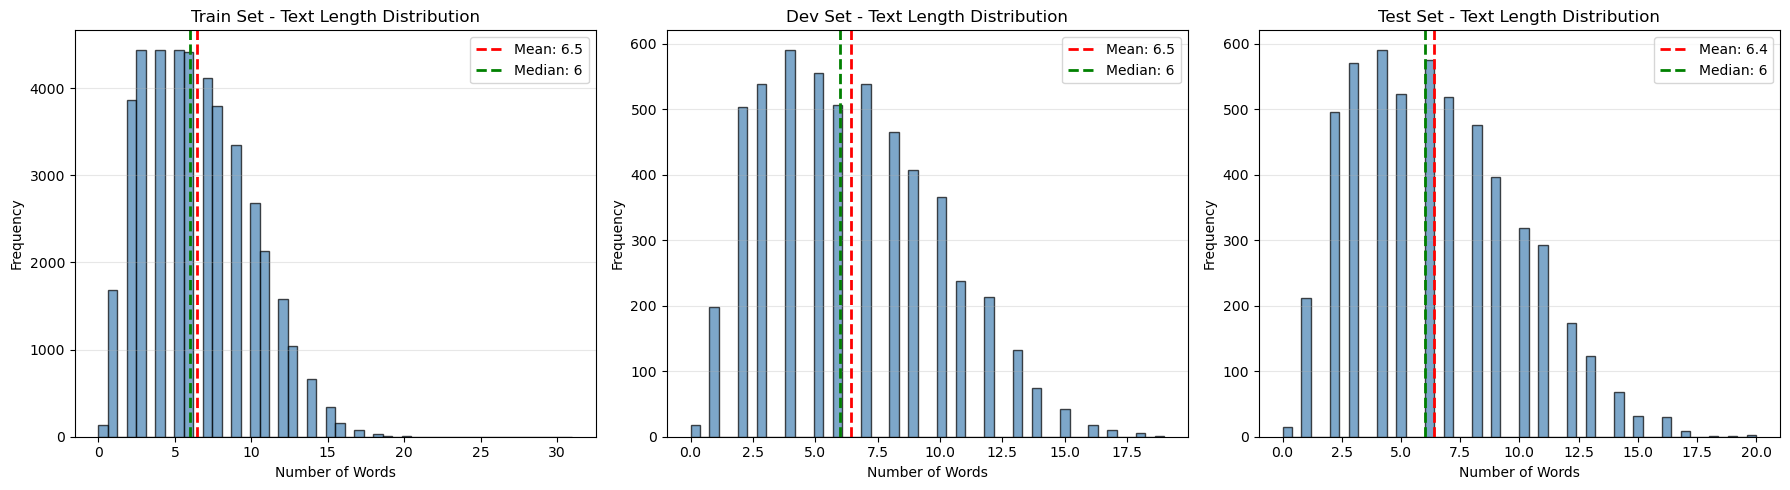


✓ Text length distribution plot saved to results/text_length_distribution.png


In [ ]:
# Step 1.5: Text Preprocessing Pipeline
print("="*60)
print("STEP 1.5: TEXT PREPROCESSING PIPELINE")
print("="*60)
print("Pipeline: Normalization (Library) → Cleaning (Library) → Stopword Removal → Stemming\n")

# Initialize stemmer and stopwords
stemmer_factory = StemmerFactory()
stemmer = stemmer_factory.create_stemmer()
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    """
    Complete preprocessing pipeline using libraries:
    1. Normalization (expand contractions) - using contractions library
    2. Cleaning (lowercase, remove URLs, emails, numbers, punct) - using clean-text library
    3. Stopword Removal
    4. Stemming
    """
    if not isinstance(text, str):
        text = str(text)
    
    # 1. NORMALIZATION: Expand contractions
    # We do this first so "don't" becomes "do not" before punctuation removal
    # Using 'contractions' library instead of manual dictionary
    text = contractions.fix(text)
    
    # 2. CLEANING & CASE FOLDING
    # Using 'clean-text' library instead of manual regex
    text = clean(text,
        fix_unicode=True,               # fix various unicode errors
        to_ascii=True,                  # transliterate to closest ASCII representation
        lower=True,                     # lowercase text
        no_line_breaks=True,           # fully strip line breaks
        no_urls=True,                  # remove URLs
        no_emails=True,                # remove email addresses
        no_phone_numbers=True,         # remove phone numbers
        no_numbers=True,               # remove numbers
        no_digits=True,                # remove digits
        no_currency_symbols=True,      # remove currency symbols
        no_punct=True,                 # remove punctuations
        replace_with_url="",
        replace_with_email="",
        replace_with_phone_number="",
        replace_with_number="",
        replace_with_digit="",
        replace_with_currency_symbol="",
        lang="en"
    )
    
    # 3. STOPWORD REMOVAL
    try:
        tokens = word_tokenize(text)
    except:
        # Fallback to simple split if tokenization fails
        tokens = text.split()
    
    filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 1]
    
    # 4. STEMMING (using Sastrawi for general purpose)
    # Note: Sastrawi is for Indonesian, for English you might want to use PorterStemmer
    # For this dataset (English GoEmotions), we'll use a simple approach
    # You can uncomment the stemming line below if needed
    # stemmed_tokens = [stemmer.stem(word) for word in filtered_tokens]
    
    # For English text, we'll skip stemming to preserve emotion keywords
    # Uncomment below for stemming:
    from nltk.stem import PorterStemmer
    porter = PorterStemmer()
    filtered_tokens = [porter.stem(word) for word in filtered_tokens]
    
    # Join tokens back into text
    preprocessed_text = ' '.join(filtered_tokens)
    
    return preprocessed_text

# Apply preprocessing to all datasets
print("Applying preprocessing to datasets...")
print("  - Normalization (contractions library)")
print("  - Cleaning (clean-text library)")
print("  - Stopword Removal (English stopwords)")
print("  - Stemming (PorterStemmer)\n")

# Store original text for comparison
train_df['text_original'] = train_df['text'].copy()
dev_df['text_original'] = dev_df['text'].copy()
test_df['text_original'] = test_df['text'].copy()

# Apply preprocessing
train_df['text'] = train_df['text'].apply(preprocess_text)
dev_df['text'] = dev_df['text'].apply(preprocess_text)
test_df['text'] = test_df['text'].apply(preprocess_text)

print("✓ Preprocessing complete!")

# Show examples of preprocessing
print("\n" + "="*80)
print("PREPROCESSING EXAMPLES")
print("="*80)
for i in range(5):
    print(f"Original: {train_df['text_original'].iloc[i]}")
    print(f"Cleaned : {train_df['text'].iloc[i]}")
    print("-" * 50)

STEP 2: CREATING BINARY DATASETS (6 EMOTIONS)
⚠️ Using preprocessed text from Step 1.5
⚠️ Using ORIGINAL imbalanced data (NO resampling)


Creating binary dataset for: ANGER
  Train: 5,316 positive, 38,094 negative
  Ratio: 1:7.17 (positive:negative)

Creating binary dataset for: DISGUST
  Train: 579 positive, 42,831 negative
  Ratio: 1:73.97 (positive:negative)

Creating binary dataset for: FEAR
  Train: 618 positive, 42,792 negative
  Ratio: 1:69.24 (positive:negative)

Creating binary dataset for: JOY
  Train: 16,941 positive, 26,469 negative
  Ratio: 1:1.56 (positive:negative)

Creating binary dataset for: SADNESS
  Train: 2,648 positive, 40,762 negative
  Ratio: 1:15.39 (positive:negative)

Creating binary dataset for: SURPRISE
  Train: 4,485 positive, 38,925 negative
  Ratio: 1:8.68 (positive:negative)

✓ Created binary datasets for 6 emotions
✓ Using ORIGINAL data (no resampling) - will use class weights instead


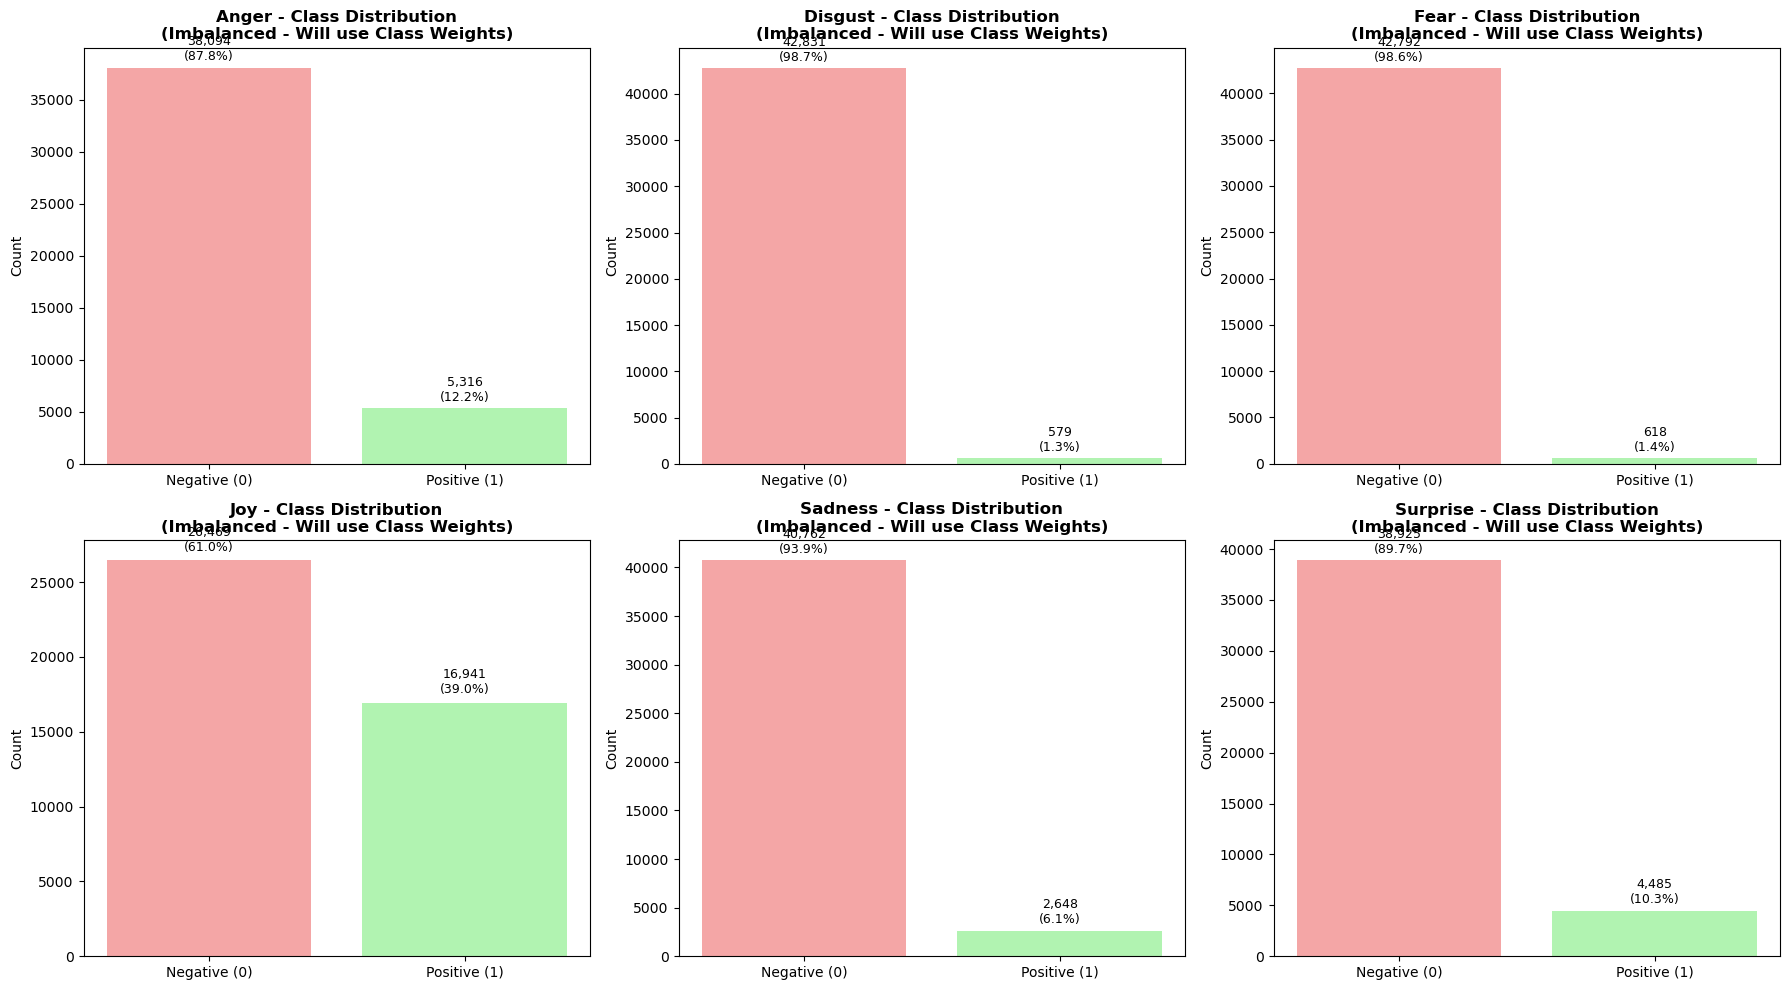


✓ Class imbalance plot saved to results/binary_class_imbalance.png

⚠️ NEXT: Will compute class weights for balanced loss function


In [5]:
# Step 2: Create Binary Datasets untuk setiap Ekman Emotion
print("="*60)
print("STEP 2: CREATING BINARY DATASETS (6 EMOTIONS)")
print("="*60)
print("⚠️ Using preprocessed text from Step 1.5")
print("⚠️ Using ORIGINAL imbalanced data (NO resampling)\n")

# Exclude 'neutral' dari 6 model binary (fokus pada 6 emosi Ekman saja)
target_emotions = ['anger', 'disgust', 'fear', 'joy', 'sadness', 'surprise']

def create_binary_dataset(df, emotion):
    """Create binary classification dataset for one emotion"""
    df_bin = df.copy()
    df_bin['label'] = (df_bin['ekman'] == emotion).astype(int)
    return df_bin

# Create binary datasets untuk setiap emosi
binary_datasets = {}

for emotion in target_emotions:
    print(f"\nCreating binary dataset for: {emotion.upper()}")

    train_bin = create_binary_dataset(train_df, emotion)
    dev_bin = create_binary_dataset(dev_df, emotion)
    test_bin = create_binary_dataset(test_df, emotion)

    # Count distribution
    train_pos = (train_bin['label'] == 1).sum()
    train_neg = (train_bin['label'] == 0).sum()

    print(f"  Train: {train_pos:,} positive, {train_neg:,} negative")
    print(f"  Ratio: 1:{train_neg/train_pos:.2f} (positive:negative)")

    binary_datasets[emotion] = {
        'train': train_bin,
        'dev': dev_bin,
        'test': test_bin,
        'ratio': train_neg / train_pos,
        'pos_count': train_pos,
        'neg_count': train_neg
    }

print(f"\n✓ Created binary datasets for {len(target_emotions)} emotions")
print("✓ Using ORIGINAL data (no resampling) - will use class weights instead")

# Visualize class imbalance
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, emotion in enumerate(target_emotions):
    train_bin = binary_datasets[emotion]['train']
    counts = train_bin['label'].value_counts().sort_index()

    axes[i].bar(['Negative (0)', 'Positive (1)'], counts.values,
                color=['lightcoral', 'lightgreen'], alpha=0.7)
    axes[i].set_title(f'{emotion.capitalize()} - Class Distribution\n(Imbalanced - Will use Class Weights)', fontweight='bold')
    axes[i].set_ylabel('Count')

    # Add count labels
    for j, count in enumerate(counts.values):
        pct = (count / len(train_bin)) * 100
        axes[i].text(j, count + len(train_bin)*0.01,
                    f'{count:,}\n({pct:.1f}%)',
                    ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig('results/binary_class_imbalance.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✓ Class imbalance plot saved to results/binary_class_imbalance.png")
print("\n⚠️ NEXT: Will compute class weights for balanced loss function")


In [6]:
# Step 2.5: Compute Class Weights for Weighted Loss
print("="*60)
print("STEP 2.5: COMPUTING CLASS WEIGHTS")
print("="*60)
print("Strategy: Balanced class weights using sklearn\n")

def create_weighted_loss(df, label_col='label', device='cuda', num_classes=2):
    """
    Computes class weights for imbalanced classification and
    returns a weighted CrossEntropyLoss for BERT training.
    
    Args:
        df: DataFrame with labels
        label_col: Name of label column (default: 'label')
        device: Device to move weights to (default: 'cuda')
        num_classes: Number of classes (default: 2 for binary)
    
    Returns:
        weights_dict: Dictionary {label_id: weight}
        weights_tensor: PyTorch tensor of weights
        loss_fn: Configured weighted CrossEntropyLoss
        label_encoder: Fitted LabelEncoder (None for already numeric labels)
    """
    
    # Extract labels
    labels = df[label_col].values
    
    # Check if labels need encoding
    label_encoder = None
    if labels.dtype == 'object' or labels.dtype.name == 'category':
        # String labels - need encoding
        label_encoder = LabelEncoder()
        labels_encoded = label_encoder.fit_transform(labels)
        print(f"  Encoded string labels: {label_encoder.classes_}")
    else:
        # Already numeric
        labels_encoded = labels
        print(f"  Labels already numeric")
    
    # Get unique classes
    unique_classes = np.unique(labels_encoded)
    
    # Original class distribution
    print(f"\nOriginal class distribution:")
    for cls in unique_classes:
        count = (labels_encoded == cls).sum()
        pct = (count / len(labels_encoded)) * 100
        print(f"  Class {cls}: {count:,} samples ({pct:.2f}%)")
    
    # Compute balanced class weights
    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=unique_classes,
        y=labels_encoded
    )
    
    # Create weights dictionary
    weights_dict = {int(cls): float(weight) for cls, weight in zip(unique_classes, class_weights)}
    
    print(f"\nComputed class weights (balanced):")
    for cls, weight in weights_dict.items():
        print(f"  Class {cls}: {weight:.4f}")
    
    # Sanity check: sum and normalized ratio
    total_weight = sum(class_weights)
    print(f"\nSanity check:")
    print(f"  Sum of weights: {total_weight:.4f}")
    print(f"  Weight ratio (0:1): 1:{class_weights[1]/class_weights[0]:.4f}")
    print(f"  Inverse of data ratio: minority gets higher weight ✓")
    
    # Convert to PyTorch tensor
    weights_tensor = torch.FloatTensor(class_weights).to(device)
    
    # Create weighted CrossEntropyLoss
    loss_fn = torch.nn.CrossEntropyLoss(weight=weights_tensor)
    
    print(f"\n✓ Weighted loss function created")
    print(f"  Type: CrossEntropyLoss with class weights")
    print(f"  Device: {device}")
    print(f"  Ready for training")
    
    return weights_dict, weights_tensor, loss_fn, label_encoder

# Compute class weights for each emotion
class_weights_info = {}

for emotion in target_emotions:
    print(f"\n{'='*60}")
    print(f"Computing class weights for: {emotion.upper()}")
    print(f"{'='*60}")
    
    train_data = binary_datasets[emotion]['train']
    
    # Compute weighted loss
    weights_dict, weights_tensor, loss_fn, label_encoder = create_weighted_loss(
        df=train_data,
        label_col='label',
        device=device,
        num_classes=2
    )
    
    # Store for later use
    class_weights_info[emotion] = {
        'weights_dict': weights_dict,
        'weights_tensor': weights_tensor,
        'loss_fn': loss_fn,
        'label_encoder': label_encoder
    }

print(f"\n{'='*60}")
print("CLASS WEIGHTS SUMMARY")
print(f"{'='*60}")
print(f"{'Emotion':<12} {'Class 0 (Neg)':<15} {'Class 1 (Pos)':<15} {'Weight Ratio'}")
print("-" * 60)
for emotion in target_emotions:
    weights = class_weights_info[emotion]['weights_dict']
    ratio = weights[1] / weights[0]
    print(f"{emotion.capitalize():<12} {weights[0]:<15.4f} {weights[1]:<15.4f} 1:{ratio:.4f}")
print("-" * 60)

print(f"\n✓ Class weights computed for all emotions")
print(f"✓ Weighted loss functions ready for training")
print(f"✓ Higher weights assigned to minority classes")
print(f"✓ No data resampling needed - using original dataset")


STEP 2.5: COMPUTING CLASS WEIGHTS
Strategy: Balanced class weights using sklearn


Computing class weights for: ANGER
  Labels already numeric

Original class distribution:
  Class 0: 38,094 samples (87.75%)
  Class 1: 5,316 samples (12.25%)

Computed class weights (balanced):
  Class 0: 0.5698
  Class 1: 4.0830

Sanity check:
  Sum of weights: 4.6527
  Weight ratio (0:1): 1:7.1659
  Inverse of data ratio: minority gets higher weight ✓

✓ Weighted loss function created
  Type: CrossEntropyLoss with class weights
  Device: cuda
  Ready for training

Computing class weights for: DISGUST
  Labels already numeric

Original class distribution:
  Class 0: 42,831 samples (98.67%)
  Class 1: 579 samples (1.33%)

Computed class weights (balanced):
  Class 0: 0.5068
  Class 1: 37.4870

Sanity check:
  Sum of weights: 37.9938
  Weight ratio (0:1): 1:73.9741
  Inverse of data ratio: minority gets higher weight ✓

✓ Weighted loss function created
  Type: CrossEntropyLoss with class weights
  Device

In [7]:
# Step 3: BERT Dataset Class dan DataLoader Setup
print("="*60)
print("STEP 3: BERT DATASET & DATALOADER SETUP")
print("="*60)
print("⚠️ Will use ORIGINAL imbalanced data with weighted loss\n")

# Initialize tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
print("✓ Tokenizer loaded: bert-base-uncased")

class BertEmotionDataset(Dataset):
    """BERT Dataset for emotion classification"""
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

def create_data_loaders(df_train, df_dev, df_test, tokenizer, batch_size=16):
    """Create DataLoaders for train, dev, and test sets"""
    train_dataset = BertEmotionDataset(
        texts=df_train['text'].values,
        labels=df_train['label'].values,
        tokenizer=tokenizer
    )

    dev_dataset = BertEmotionDataset(
        texts=df_dev['text'].values,
        labels=df_dev['label'].values,
        tokenizer=tokenizer
    )

    test_dataset = BertEmotionDataset(
        texts=df_test['text'].values,
        labels=df_test['label'].values,
        tokenizer=tokenizer
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    return train_loader, dev_loader, test_loader

print("✓ BERT Dataset class defined")
print("✓ DataLoader creation function ready")
print("✓ Training will use ORIGINAL imbalanced data")
print("✓ Class imbalance handled by weighted loss function")


STEP 3: BERT DATASET & DATALOADER SETUP
⚠️ Will use ORIGINAL imbalanced data with weighted loss

✓ Tokenizer loaded: bert-base-uncased
✓ BERT Dataset class defined
✓ DataLoader creation function ready
✓ Training will use ORIGINAL imbalanced data
✓ Class imbalance handled by weighted loss function


In [8]:
# Step 5: Training Functions (Fixed Hyperparameters + Weighted Loss)
print("="*60)
print("STEP 5: TRAINING FUNCTIONS (FIXED HYPERPARAMETERS + WEIGHTED LOSS)")
print("="*60)

import torch
from torch.cuda.amp import autocast, GradScaler
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score

# Fixed hyperparameters berdasarkan literatur
FIXED_PARAMS = {
    'learning_rate': 2e-5,
    'batch_size': 32,
    'epochs': 50,
    'weight_decay': 0.01
}

print(f"Fixed Hyperparameters:")
print(f"  Learning Rate: {FIXED_PARAMS['learning_rate']}")
print(f"  Batch Size: {FIXED_PARAMS['batch_size']}")
print(f"  Epochs: {FIXED_PARAMS['epochs']}")
print(f"  Weight Decay: {FIXED_PARAMS['weight_decay']}")
print(f"  Optimizer: AdamW")
print(f"  Architecture: BERT (12 layers, 12 heads, hidden=768)")
print(f"  Loss: Weighted CrossEntropyLoss")

# -------------------------------------------------------------
# ✅ Training Loop with AMP and Weighted Loss
# -------------------------------------------------------------
def train_epoch_amp_weighted(model, data_loader, optimizer, scheduler, device, scaler, loss_fn):
    """Training loop with automatic mixed precision and weighted loss"""
    model.train()
    total_loss = 0.0
    predictions, true_labels = [], []

    for batch in data_loader:
        optimizer.zero_grad(set_to_none=True)

        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        with autocast():  # mixed precision
            # Get logits (no loss from model, we'll use weighted loss)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Compute weighted loss
            loss = loss_fn(logits, labels)

        scaler.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).detach().cpu().numpy()
        predictions.extend(preds)
        true_labels.extend(labels.detach().cpu().numpy())

        del input_ids, attention_mask, labels, outputs, logits
        torch.cuda.empty_cache()

    avg_loss = total_loss / len(data_loader)
    accuracy = accuracy_score(true_labels, predictions)
    return avg_loss, accuracy


# -------------------------------------------------------------
# ✅ Evaluation Function (No Grad + AMP)
# -------------------------------------------------------------
def evaluate_model_amp(model, data_loader, device):
    """Evaluation with automatic mixed precision"""
    model.eval()
    predictions, true_labels, probabilities = [], [], []

    with torch.no_grad(), autocast():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=1)

            preds = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(preds)
            true_labels.extend(labels.cpu().numpy())
            probabilities.extend(probs[:, 1].cpu().numpy())

            del input_ids, attention_mask, labels, outputs, logits, probs
            torch.cuda.empty_cache()

    acc = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='binary', zero_division=0)
    try:
        roc_auc = roc_auc_score(true_labels, probabilities)
    except ValueError:
        roc_auc = 0.0

    return {
        'accuracy': acc, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1, 
        'roc_auc': roc_auc,
        'predictions': predictions,
        'true_labels': true_labels,
        'probabilities': probabilities
    }


# -------------------------------------------------------------
# ✅ Training Function with Fixed Hyperparameters + Weighted Loss
# -------------------------------------------------------------
def train_bert_model_weighted(train_loader, dev_loader, test_loader, device, emotion_name, loss_fn, params=FIXED_PARAMS):
    """Train BERT model with fixed hyperparameters and weighted loss (no tuning)"""
    print(f"\n{'='*60}")
    print(f"🧠 Training {emotion_name.upper()}")
    print(f"{'='*60}")
    print(f"Parameters: LR={params['learning_rate']}, Batch={params['batch_size']}, "
          f"Epochs={params['epochs']}, Weight Decay={params['weight_decay']}")
    print(f"Loss Function: Weighted CrossEntropyLoss")

    # Initialize BERT model (12 layers, 12 heads, hidden=768)
    model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2).to(device)
    
    # AdamW optimizer with weight decay
    optimizer = AdamW(
        model.parameters(), 
        lr=params['learning_rate'], 
        weight_decay=params['weight_decay'],
        eps=1e-8
    )
    
    # Learning rate scheduler
    total_steps = len(train_loader) * params['epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer, 
        num_warmup_steps=0, 
        num_training_steps=total_steps
    )
    
    # Mixed precision scaler
    scaler = GradScaler()

    best_f1, best_epoch = 0, 0
    best_dev_metrics = None
    best_model_state = None
    
    # Track training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'dev_f1': [],
        'dev_acc': []
    }

    print(f"\nStarting training for {params['epochs']} epochs...")
    print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Dev F1':<12} {'Dev Acc':<12} {'Status'}")
    print("-" * 70)

    for epoch in range(params['epochs']):
        # Training with weighted loss
        train_loss, train_acc = train_epoch_amp_weighted(model, train_loader, optimizer, scheduler, device, scaler, loss_fn)
        
        # Validation
        dev_metrics = evaluate_model_amp(model, dev_loader, device)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['dev_f1'].append(dev_metrics['f1'])
        history['dev_acc'].append(dev_metrics['accuracy'])
        
        # Track best model
        status = ""
        if dev_metrics['f1'] > best_f1:
            best_f1 = dev_metrics['f1']
            best_epoch = epoch + 1
            best_dev_metrics = dev_metrics
            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
            status = "⭐ BEST"
        
        # Print progress every 5 epochs or if best
        if (epoch + 1) % 5 == 0 or status:
            print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} "
                  f"{dev_metrics['f1']:<12.4f} {dev_metrics['accuracy']:<12.4f} {status}")
        
        torch.cuda.empty_cache()

    print("-" * 70)
    print(f"✓ Training completed! Best epoch: {best_epoch} (Dev F1: {best_f1:.4f})")

    # Load best model from memory
    if best_model_state:
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})

    # Evaluate on test set
    print(f"\nEvaluating on test set...")
    test_metrics = evaluate_model_amp(model, test_loader, device)

    # Save model
    os.makedirs('results', exist_ok=True)
    model_path = f"results/best_model_{emotion_name}.pt"
    torch.save(best_model_state, model_path)
    print(f"✓ Model saved to {model_path}")

    return {
        'emotion': emotion_name,
        'params': params,
        'best_epoch': best_epoch,
        'dev_metrics': best_dev_metrics,
        'test_metrics': test_metrics,
        'history': history,
        'model': model
    }


print("\n✓ Training functions ready (Fixed hyperparameters + Weighted loss)")


# -------------------------------------------------------------
# Step 6: Train All 6 Binary Models (WITH CLASS WEIGHTS)
# -------------------------------------------------------------
print("\n" + "="*60)
print("STEP 6: TRAIN 6 BINARY MODELS (FIXED HYPERPARAMETERS + CLASS WEIGHTS)")
print("="*60)
print(f"✅ Using ORIGINAL imbalanced data with WEIGHTED LOSS")
print(f"✅ Dev/Test data also original")
print(f"⚠️ Fixed hyperparameters (NO tuning/grid search)")

all_results = {}
best_models_per_emotion = {}

for emotion in target_emotions:
    print(f"\n{'='*60}")
    print(f"TRAINING: {emotion.upper()}")
    print(f"{'='*60}")

    # Use ORIGINAL training data
    train_data = binary_datasets[emotion]['train']
    dev_data = binary_datasets[emotion]['dev']
    test_data = binary_datasets[emotion]['test']
    
    # Get weighted loss function for this emotion
    loss_fn = class_weights_info[emotion]['loss_fn']
    weights_dict = class_weights_info[emotion]['weights_dict']
    
    print(f"Dataset Statistics:")
    print(f"  Train samples: {len(train_data):,} (original imbalanced)")
    print(f"  Positive class: {(train_data['label']==1).sum():,} ({(train_data['label']==1).sum()/len(train_data)*100:.1f}%)")
    print(f"  Negative class: {(train_data['label']==0).sum():,} ({(train_data['label']==0).sum()/len(train_data)*100:.1f}%)")
    print(f"  Class ratio: 1:{binary_datasets[emotion]['ratio']:.2f}")
    print(f"\nClass Weights:")
    print(f"  Negative (0): {weights_dict[0]:.4f}")
    print(f"  Positive (1): {weights_dict[1]:.4f}")
    print(f"  Weight ratio: 1:{weights_dict[1]/weights_dict[0]:.4f}")

    # Create data loaders with FIXED batch size
    train_loader, dev_loader, test_loader = create_data_loaders(
        train_data, dev_data, test_data, 
        tokenizer, 
        batch_size=FIXED_PARAMS['batch_size']
    )

    # Train model with fixed hyperparameters and weighted loss
    result = train_bert_model_weighted(
        train_loader, dev_loader, test_loader, 
        device, emotion, loss_fn
    )

    # Store results
    all_results[emotion] = result
    best_models_per_emotion[emotion] = {
        'params': result['params'],
        'best_epoch': result['best_epoch'],
        'dev_metrics': result['dev_metrics'],
        'test_metrics': result['test_metrics'],
        'class_weights': weights_dict
    }
    
    # Clean up
    del result['model']
    torch.cuda.empty_cache()
    
    print(f"\n✓ {emotion.upper()} completed!")
    print(f"  Best Epoch: {result['best_epoch']}")
    print(f"  Dev F1: {result['dev_metrics']['f1']:.4f}")
    print(f"  Test F1: {result['test_metrics']['f1']:.4f}")
    print(f"  Test Precision: {result['test_metrics']['precision']:.4f}")
    print(f"  Test Recall: {result['test_metrics']['recall']:.4f}")
    print(f"  Test ROC-AUC: {result['test_metrics']['roc_auc']:.4f}")

print(f"\n{'='*80}")
print("SUMMARY: BINARY MODELS RESULTS (WITH CLASS WEIGHTS)")
print(f"{'='*80}")
print(f"{'Emotion':<12} {'Best Epoch':<12} {'Dev F1':<10} {'Test F1':<10} {'Test Prec':<10} {'Test Rec':<10} {'ROC-AUC':<10}")
print("-" * 80)
for emotion, result in best_models_per_emotion.items():
    print(f"{emotion.capitalize():<12} {result['best_epoch']:<12} "
          f"{result['dev_metrics']['f1']:<10.4f} {result['test_metrics']['f1']:<10.4f} "
          f"{result['test_metrics']['precision']:<10.4f} {result['test_metrics']['recall']:<10.4f} "
          f"{result['test_metrics']['roc_auc']:<10.4f}")
print("-" * 80)


STEP 5: TRAINING FUNCTIONS (FIXED HYPERPARAMETERS + WEIGHTED LOSS)
Fixed Hyperparameters:
  Learning Rate: 2e-05
  Batch Size: 32
  Epochs: 50
  Weight Decay: 0.01
  Optimizer: AdamW
  Architecture: BERT (12 layers, 12 heads, hidden=768)
  Loss: Weighted CrossEntropyLoss

✓ Training functions ready (Fixed hyperparameters + Weighted loss)

STEP 6: TRAIN 6 BINARY MODELS (FIXED HYPERPARAMETERS + CLASS WEIGHTS)
✅ Using ORIGINAL imbalanced data with WEIGHTED LOSS
✅ Dev/Test data also original
⚠️ Fixed hyperparameters (NO tuning/grid search)

TRAINING: ANGER
Dataset Statistics:
  Train samples: 43,410 (original imbalanced)
  Positive class: 5,316 (12.2%)
  Negative class: 38,094 (87.8%)
  Class ratio: 1:7.17

Class Weights:
  Negative (0): 0.5698
  Positive (1): 4.0830
  Weight ratio: 1:7.1659

🧠 Training ANGER
Parameters: LR=2e-05, Batch=32, Epochs=50, Weight Decay=0.01
Loss Function: Weighted CrossEntropyLoss


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        0.5708       0.7398       0.4823       0.8223       ⭐ BEST
5        0.2525       0.9310       0.4350       0.8645       
10       0.3369       0.9811       0.3493       0.8771       
15       0.1836       0.9899       0.4097       0.8513       
20       0.1481       0.9940       0.4013       0.8680       
25       0.1103       0.9950       0.3709       0.8725       
30       0.0916       0.9961       0.3905       0.8682       
35       0.0781       0.9967       0.3979       0.8706       
40       0.0693       0.9968       0.4010       0.8723       
45       0.0643       0.9971       0.3818       0.8723       
50       0.0623       0.9972       0.3864       0.8736       
----------------------------------------------------------------------
✓ Training completed! Best epoch: 1 (Dev F1: 0.4823)

Evaluating o

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
2        2.4451       0.9877       0.4040       0.9891       ⭐ BEST
3        1.8985       0.9882       0.4545       0.9889       ⭐ BEST
5        0.8078       0.9935       0.4088       0.9851       
10       0.2140       0.9982       0.4030       0.9853       
15       0.0798       0.9994       0.3898       0.9867       
20       0.0500       0.9997       0.4242       0.9860       
25       0.0799       0.9994       0.4202       0.9873       
30       0.0314       0.9997       0.4194       0.9867       
35       0.0475       0.9997       0.4127       0.9864       
40       0.0495       0.9997       0.4160       0.9865       
45       0.0591       0.9997       0.4032       0.9864       
50       0.0595       0.9997       0.4032       0.9864       
---------------------------------------------------------------------

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        2.6064       0.9837       0.4691       0.9842       ⭐ BEST
5        0.8201       0.9925       0.5195       0.9864       ⭐ BEST
10       0.1670       0.9979       0.4118       0.9853       
15       0.0356       0.9997       0.4865       0.9825       
20       0.0276       0.9998       0.4571       0.9860       
25       0.0237       0.9998       0.4179       0.9856       
30       0.0198       0.9999       0.4029       0.9847       
35       0.0187       0.9999       0.4317       0.9854       
40       0.0174       0.9999       0.4648       0.9860       
45       0.0170       0.9999       0.4672       0.9865       
50       0.0177       0.9999       0.4681       0.9862       
----------------------------------------------------------------------
✓ Training completed! Best epoch: 5 (Dev F1: 0.5195)

Evalua

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        0.5034       0.7672       0.7652       0.8015       ⭐ BEST
2        0.4232       0.8240       0.7824       0.8249       ⭐ BEST
4        0.3785       0.8458       0.7872       0.8290       ⭐ BEST
5        0.3354       0.8662       0.7801       0.8242       
10       0.1767       0.9364       0.7688       0.8140       
15       0.1262       0.9654       0.7433       0.7956       
20       0.1474       0.9815       0.7526       0.8013       
25       0.1190       0.9874       0.7563       0.8030       
30       0.0839       0.9911       0.7605       0.8083       
35       0.0640       0.9927       0.7616       0.8091       
40       0.0486       0.9941       0.7546       0.8113       
45       0.0470       0.9946       0.7634       0.8116       
50       0.0415       0.9950       0.7638       0.8133       
-

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        0.5456       0.8655       0.4930       0.9268       ⭐ BEST
4        0.4331       0.9643       0.5016       0.9432       ⭐ BEST
5        0.5329       0.9688       0.4806       0.9335       
10       0.2163       0.9935       0.4854       0.9449       
15       0.1234       0.9968       0.4745       0.9469       
20       0.0773       0.9978       0.4916       0.9501       
25       0.0521       0.9986       0.4631       0.9517       
30       0.0402       0.9987       0.4596       0.9532       
35       0.0435       0.9988       0.4583       0.9486       
40       0.0304       0.9990       0.4708       0.9499       
45       0.0341       0.9990       0.4538       0.9499       
50       0.0393       0.9990       0.4573       0.9497       
---------------------------------------------------------------------

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev F1       Dev Acc      Status
----------------------------------------------------------------------
1        0.6473       0.6776       0.3420       0.8327       ⭐ BEST
2        0.5730       0.7482       0.3691       0.8312       ⭐ BEST
5        0.3274       0.9020       0.3576       0.8358       
10       0.3216       0.9692       0.3157       0.8666       
15       0.2647       0.9887       0.3070       0.8918       
20       0.1917       0.9922       0.3051       0.8867       
25       0.1394       0.9943       0.3136       0.8887       
30       0.1200       0.9952       0.3050       0.8900       
35       0.1132       0.9949       0.3102       0.8918       
40       0.0933       0.9959       0.3096       0.8948       
45       0.0924       0.9961       0.2967       0.8951       
50       0.0871       0.9962       0.2968       0.8961       
---------------------------------------------------------------------

In [9]:
# Step 7: Train Baseline Multi-class BERT Model (Fixed Hyperparameters + Class Weights)
print("="*60)
print("STEP 7: TRAINING BASELINE MULTI-CLASS BERT (WITH CLASS WEIGHTS)")
print("="*60)

# Prepare multi-class dataset (exclude neutral for fair comparison)
train_mc = train_df[train_df['ekman'].isin(target_emotions)].copy()
dev_mc = dev_df[dev_df['ekman'].isin(target_emotions)].copy()
test_mc = test_df[test_df['ekman'].isin(target_emotions)].copy()

# Encode labels
label2id = {emotion: i for i, emotion in enumerate(target_emotions)}
id2label = {i: emotion for emotion, i in label2id.items()}

train_mc['label'] = train_mc['ekman'].map(label2id)
dev_mc['label'] = dev_mc['ekman'].map(label2id)
test_mc['label'] = test_mc['ekman'].map(label2id)

print(f"Multi-class dataset sizes:")
print(f"  Train: {len(train_mc):,} samples")
print(f"  Dev: {len(dev_mc):,} samples")
print(f"  Test: {len(test_mc):,} samples")

print(f"\nClass distribution (original imbalanced):")
for emotion in target_emotions:
    count = (train_mc['ekman'] == emotion).sum()
    pct = count / len(train_mc) * 100
    print(f"  {emotion.capitalize():<12}: {count:5,} ({pct:5.1f}%)")

# Compute class weights for multi-class
print(f"\n{'='*60}")
print("COMPUTING CLASS WEIGHTS FOR MULTI-CLASS")
print(f"{'='*60}")

weights_dict_mc, weights_tensor_mc, loss_fn_mc, _ = create_weighted_loss(
    df=train_mc,
    label_col='label',
    device=device,
    num_classes=len(target_emotions)
)

# Use SAME fixed hyperparameters as binary models
print(f"\n{'='*60}")
print(f"Using FIXED hyperparameters (same as binary models):")
print(f"  Learning Rate: {FIXED_PARAMS['learning_rate']}")
print(f"  Batch Size: {FIXED_PARAMS['batch_size']}")
print(f"  Epochs: {FIXED_PARAMS['epochs']}")
print(f"  Weight Decay: {FIXED_PARAMS['weight_decay']}")
print(f"  Loss: Weighted CrossEntropyLoss")
print(f"{'='*60}")

# Create data loaders
train_loader_mc, dev_loader_mc, test_loader_mc = create_data_loaders(
    train_mc, dev_mc, test_mc,
    tokenizer,
    batch_size=FIXED_PARAMS['batch_size']
)

# Initialize multi-class model (12 layers, 12 heads, hidden=768)
model_mc = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=len(target_emotions)
)
model_mc = model_mc.to(device)

# AdamW optimizer with weight decay
optimizer_mc = AdamW(
    model_mc.parameters(), 
    lr=FIXED_PARAMS['learning_rate'],
    weight_decay=FIXED_PARAMS['weight_decay'],
    eps=1e-8
)

# Learning rate scheduler
total_steps_mc = len(train_loader_mc) * FIXED_PARAMS['epochs']
scheduler_mc = get_linear_schedule_with_warmup(
    optimizer_mc,
    num_warmup_steps=0,
    num_training_steps=total_steps_mc
)

# Mixed precision scaler
scaler_mc = GradScaler()

# Training loop
print(f"\nStarting multi-class training for {FIXED_PARAMS['epochs']} epochs...")
print(f"{'Epoch':<8} {'Train Loss':<12} {'Train Acc':<12} {'Dev Macro-F1':<12} {'Status'}")
print("-" * 60)

best_f1_mc = 0
best_epoch_mc = 0
best_dev_macro_f1 = 0
best_model_state_mc = None

history_mc = {
    'train_loss': [],
    'train_acc': [],
    'dev_macro_f1': []
}

for epoch in range(FIXED_PARAMS['epochs']):
    # Training with AMP and weighted loss
    model_mc.train()
    total_loss = 0.0
    predictions_train = []
    true_labels_train = []

    for batch in train_loader_mc:
        optimizer_mc.zero_grad(set_to_none=True)

        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        with autocast():
            # Get logits
            outputs = model_mc(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            # Compute weighted loss
            loss = loss_fn_mc(logits, labels)

        scaler_mc.scale(loss).backward()
        torch.nn.utils.clip_grad_norm_(model_mc.parameters(), 1.0)
        scaler_mc.step(optimizer_mc)
        scaler_mc.update()
        scheduler_mc.step()

        total_loss += loss.item()
        preds = torch.argmax(logits, dim=1).cpu().numpy()
        predictions_train.extend(preds)
        true_labels_train.extend(labels.cpu().numpy())

        del input_ids, attention_mask, labels, outputs, logits
        torch.cuda.empty_cache()

    train_loss = total_loss / len(train_loader_mc)
    train_acc = accuracy_score(true_labels_train, predictions_train)

    # Validation
    model_mc.eval()
    predictions_mc = []
    true_labels_mc = []

    with torch.no_grad(), autocast():
        for batch in dev_loader_mc:
            input_ids = batch['input_ids'].to(device, non_blocking=True)
            attention_mask = batch['attention_mask'].to(device, non_blocking=True)
            labels = batch['labels'].to(device, non_blocking=True)

            outputs = model_mc(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()

            predictions_mc.extend(preds)
            true_labels_mc.extend(labels.cpu().numpy())

            del input_ids, attention_mask, labels, outputs, logits
            torch.cuda.empty_cache()

    # Calculate macro F1 for multi-class
    _, _, f1_macro, _ = precision_recall_fscore_support(
        true_labels_mc, predictions_mc, average='macro', zero_division=0
    )

    # Save history
    history_mc['train_loss'].append(train_loss)
    history_mc['train_acc'].append(train_acc)
    history_mc['dev_macro_f1'].append(f1_macro)

    # Track best model
    status = ""
    if f1_macro > best_f1_mc:
        best_f1_mc = f1_macro
        best_epoch_mc = epoch + 1
        best_dev_macro_f1 = f1_macro
        best_model_state_mc = {k: v.cpu().clone() for k, v in model_mc.state_dict().items()}
        status = "⭐ BEST"

    # Print progress every 5 epochs or if best
    if (epoch + 1) % 5 == 0 or status:
        print(f"{epoch+1:<8} {train_loss:<12.4f} {train_acc:<12.4f} {f1_macro:<12.4f} {status}")

print("-" * 60)
print(f"✓ Multi-class training completed! Best epoch: {best_epoch_mc} (Dev Macro-F1: {best_f1_mc:.4f})")

# Load best model and evaluate on test set
if best_model_state_mc:
    model_mc.load_state_dict({k: v.to(device) for k, v in best_model_state_mc.items()})

print(f"\nEvaluating on test set...")
model_mc.eval()

predictions_test_mc = []
true_labels_test_mc = []

with torch.no_grad(), autocast():
    for batch in test_loader_mc:
        input_ids = batch['input_ids'].to(device, non_blocking=True)
        attention_mask = batch['attention_mask'].to(device, non_blocking=True)
        labels = batch['labels'].to(device, non_blocking=True)

        outputs = model_mc(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        preds = torch.argmax(logits, dim=1).cpu().numpy()

        predictions_test_mc.extend(preds)
        true_labels_test_mc.extend(labels.cpu().numpy())

        del input_ids, attention_mask, labels, outputs, logits

# Calculate overall test metrics
test_macro_f1 = precision_recall_fscore_support(
    true_labels_test_mc, predictions_test_mc, average='macro', zero_division=0
)[2]

print(f"✓ Test Macro-F1: {test_macro_f1:.4f}")

# Calculate per-class metrics for baseline
print(f"\nPer-emotion performance on test set:")
baseline_metrics = {}
for i, emotion in enumerate(target_emotions):
    # Binary evaluation for each emotion
    true_binary = [1 if label == i else 0 for label in true_labels_test_mc]
    pred_binary = [1 if pred == i else 0 for pred in predictions_test_mc]

    precision, recall, f1, _ = precision_recall_fscore_support(
        true_binary, pred_binary, average='binary', zero_division=0
    )

    baseline_metrics[emotion] = {
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'accuracy': accuracy_score(true_binary, pred_binary)
    }
    
    print(f"  {emotion.capitalize():<12}: F1={f1:.4f}, Precision={precision:.4f}, Recall={recall:.4f}")

# Save baseline model
os.makedirs('results', exist_ok=True)
torch.save(best_model_state_mc, 'results/best_model_multiclass.pt')
print(f"\n✓ Baseline model saved to results/best_model_multiclass.pt")

# Store baseline results
baseline_result = {
    'params': FIXED_PARAMS,
    'best_epoch': best_epoch_mc,
    'dev_macro_f1': best_dev_macro_f1,
    'test_macro_f1': test_macro_f1,
    'per_emotion_metrics': baseline_metrics,
    'history': history_mc,
    'class_weights': weights_dict_mc
}

print(f"\n{'='*60}")
print("BASELINE MULTI-CLASS MODEL COMPLETED (WITH CLASS WEIGHTS)")
print(f"{'='*60}")


STEP 7: TRAINING BASELINE MULTI-CLASS BERT (WITH CLASS WEIGHTS)
Multi-class dataset sizes:
  Train: 30,587 samples
  Dev: 3,834 samples
  Test: 3,821 samples

Class distribution (original imbalanced):
  Anger       : 5,316 ( 17.4%)
  Disgust     :   579 (  1.9%)
  Fear        :   618 (  2.0%)
  Joy         : 16,941 ( 55.4%)
  Sadness     : 2,648 (  8.7%)
  Surprise    : 4,485 ( 14.7%)

COMPUTING CLASS WEIGHTS FOR MULTI-CLASS
  Labels already numeric

Original class distribution:
  Class 0: 5,316 samples (17.38%)
  Class 1: 579 samples (1.89%)
  Class 2: 618 samples (2.02%)
  Class 3: 16,941 samples (55.39%)
  Class 4: 2,648 samples (8.66%)
  Class 5: 4,485 samples (14.66%)

Computed class weights (balanced):
  Class 0: 0.9590
  Class 1: 8.8045
  Class 2: 8.2489
  Class 3: 0.3009
  Class 4: 1.9252
  Class 5: 1.1366

Sanity check:
  Sum of weights: 21.3752
  Weight ratio (0:1): 1:9.1813
  Inverse of data ratio: minority gets higher weight ✓

✓ Weighted loss function created
  Type: Cross

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Starting multi-class training for 50 epochs...
Epoch    Train Loss   Train Acc    Dev Macro-F1 Status
------------------------------------------------------------
1        1.5077       0.4795       0.5391       ⭐ BEST
2        1.0493       0.6445       0.5593       ⭐ BEST
3        0.9200       0.6796       0.5798       ⭐ BEST
4        0.7517       0.7168       0.5820       ⭐ BEST
5        0.6062       0.7543       0.5918       ⭐ BEST
10       0.1975       0.9041       0.5673       
15       0.1015       0.9579       0.5680       
20       0.0823       0.9777       0.5679       
25       0.1216       0.9827       0.5649       
30       0.1016       0.9861       0.5765       
35       0.0617       0.9916       0.5666       
40       0.0504       0.9923       0.5699       
45       0.0439       0.9936       0.5789       
50       0.0372       0.9940       0.5763       
------------------------------------------------------------
✓ Multi-class training completed! Best epoch: 5 (Dev Macro-

In [12]:
# Step 8: Compare Results - Binary Models vs Baseline Multi-class (Both with Class Weights)
print("="*80)
print("STEP 8: RESULTS COMPARISON (ALL MODELS USE CLASS-WEIGHTED LOSS)")
print("="*80)

# Check if binary_results exists, if not try to load from best_models_per_emotion or all_results
if 'binary_results' not in globals():
    print("⚠️ binary_results not found, attempting to reconstruct from available data...")
    
    # Try to use best_models_per_emotion if it exists
    if 'best_models_per_emotion' in globals() and best_models_per_emotion:
        print("✓ Found best_models_per_emotion, using it as binary_results")
        binary_results = best_models_per_emotion
    elif 'all_results' in globals() and all_results:
        print("✓ Found all_results, using it as binary_results")
        binary_results = all_results
    else:
        print("❌ ERROR: No binary model results found!")
        print("⚠️ Please run Step 6 (Binary Models Training) first before running this comparison.")
        print("\nSkipping comparison and using only baseline results...")
        
        # Show baseline only
        print(f"\n{'='*80}")
        print("BASELINE MULTI-CLASS RESULTS ONLY")
        print(f"{'='*80}")
        print(f"Test Macro-F1: {baseline_result['test_macro_f1']:.4f}")
        print(f"Dev Macro-F1: {baseline_result['dev_macro_f1']:.4f}")
        print(f"Best Epoch: {baseline_result['best_epoch']}")
        
        print("\nPer-emotion metrics:")
        for emotion in target_emotions:
            metrics = baseline_result['per_emotion_metrics'][emotion]
            print(f"  {emotion.capitalize():<12}: F1={metrics['f1']:.4f}, P={metrics['precision']:.4f}, R={metrics['recall']:.4f}")
        
        # Set flag to skip rest of cell
        import sys
        print("\n" + "="*80)
        binary_results = None

if binary_results is not None:
    # Create comprehensive comparison dataframe
    comparison_data = []

    # Add baseline multi-class results
    comparison_data.append({
        'Model': 'Baseline (Multi-class)',
        'Type': 'Multi-class',
        'Approach': 'Weighted Loss',
        'Test Macro-F1': baseline_result['test_macro_f1'],
        'Dev Macro-F1': baseline_result['dev_macro_f1'],
        'Best Epoch': baseline_result['best_epoch']
    })

    # Add binary model results
    for emotion in target_emotions:
        comparison_data.append({
            'Model': f'Binary ({emotion.capitalize()})',
            'Type': 'Binary',
            'Approach': 'Weighted Loss',
            'Test Macro-F1': binary_results[emotion]['test_macro_f1'],
            'Dev Macro-F1': binary_results[emotion]['dev_macro_f1'],
            'Best Epoch': binary_results[emotion]['best_epoch']
        })

    comparison_df = pd.DataFrame(comparison_data)

    # Display comparison table
    print("\n" + "="*80)
    print("MODEL PERFORMANCE COMPARISON")
    print("="*80)
    print(comparison_df.to_string(index=False))
    print("="*80)

    # Calculate average binary model performance
    avg_binary_f1 = comparison_df[comparison_df['Type'] == 'Binary']['Test Macro-F1'].mean()
    baseline_f1 = baseline_result['test_macro_f1']

    print(f"\nSummary:")
    print(f"  Baseline Multi-class Test Macro-F1: {baseline_f1:.4f}")
    print(f"  Average Binary Models Test Macro-F1: {avg_binary_f1:.4f}")
    print(f"  Difference: {avg_binary_f1 - baseline_f1:+.4f}")

    if avg_binary_f1 > baseline_f1:
        print(f"  ✓ Binary models outperform baseline by {(avg_binary_f1 - baseline_f1)*100:.2f}%")
    else:
        print(f"  ✗ Baseline outperforms binary models by {(baseline_f1 - avg_binary_f1)*100:.2f}%")

    # Per-emotion F1 comparison
    print(f"\n{'='*80}")
    print("PER-EMOTION F1 SCORE COMPARISON")
    print(f"{'='*80}")
    print(f"{'Emotion':<12} {'Binary F1':<12} {'Baseline F1':<12} {'Improvement':<12}")
    print("-"*80)

    per_emotion_improvements = []
    for emotion in target_emotions:
        binary_f1 = binary_results[emotion]['test_metrics']['f1']
        baseline_f1_emotion = baseline_result['per_emotion_metrics'][emotion]['f1']
        improvement = binary_f1 - baseline_f1_emotion
        per_emotion_improvements.append(improvement)
        
        symbol = "↑" if improvement > 0 else "↓"
        print(f"{emotion.capitalize():<12} {binary_f1:<12.4f} {baseline_f1_emotion:<12.4f} {improvement:+.4f} {symbol}")

    print("-"*80)
    avg_improvement = sum(per_emotion_improvements) / len(per_emotion_improvements)
    print(f"{'Average':<12} {avg_binary_f1:<12.4f} {baseline_result['test_macro_f1']:<12.4f} {avg_improvement:+.4f}")
    print(f"{'='*80}")

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # 1. Test Macro-F1 comparison
    ax = axes[0, 0]
    models = ['Baseline\n(Multi-class)'] + [e.capitalize() for e in target_emotions]
    f1_scores = [baseline_result['test_macro_f1']] + [binary_results[e]['test_macro_f1'] for e in target_emotions]
    colors = ['#FF6B6B'] + ['#4ECDC4'] * len(target_emotions)

    bars = ax.bar(models, f1_scores, color=colors, alpha=0.7, edgecolor='black')
    ax.axhline(y=baseline_result['test_macro_f1'], color='red', linestyle='--', alpha=0.5, label='Baseline')
    ax.set_ylabel('Test Macro-F1', fontsize=12, fontweight='bold')
    ax.set_title('Test Macro-F1: Binary Models vs Baseline (All with Weighted Loss)', fontsize=13, fontweight='bold')
    ax.set_ylim([0, 1.0])
    ax.legend()
    ax.grid(axis='y', alpha=0.3)

    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}',
                ha='center', va='bottom', fontsize=10)

    # 2. Per-emotion F1 comparison
    ax = axes[0, 1]
    x = range(len(target_emotions))
    width = 0.35

    binary_f1s = [binary_results[e]['test_metrics']['f1'] for e in target_emotions]
    baseline_f1s = [baseline_result['per_emotion_metrics'][e]['f1'] for e in target_emotions]

    bars1 = ax.bar([i - width/2 for i in x], binary_f1s, width, label='Binary Models', color='#4ECDC4', edgecolor='black')
    bars2 = ax.bar([i + width/2 for i in x], baseline_f1s, width, label='Baseline', color='#FF6B6B', edgecolor='black')

    ax.set_ylabel('F1 Score', fontsize=12, fontweight='bold')
    ax.set_title('Per-Emotion F1: Binary vs Baseline (Both with Weighted Loss)', fontsize=13, fontweight='bold')
    ax.set_xticks(x)
    ax.set_xticklabels([e.capitalize() for e in target_emotions], rotation=45, ha='right')
    ax.legend()
    ax.set_ylim([0, 1.0])
    ax.grid(axis='y', alpha=0.3)

    # 3. Training convergence comparison
    ax = axes[1, 0]
    # Plot baseline
    epochs = range(1, len(baseline_result['history']['dev_macro_f1']) + 1)
    ax.plot(epochs, baseline_result['history']['dev_macro_f1'], 
            label='Baseline (Multi-class)', color='#FF6B6B', linewidth=2, marker='o', markersize=3)

    # Plot binary models
    for emotion in target_emotions:
        history = binary_results[emotion]['history']
        epochs_bin = range(1, len(history['dev_macro_f1']) + 1)
        ax.plot(epochs_bin, history['dev_macro_f1'], 
                label=f'{emotion.capitalize()}', alpha=0.6, linewidth=1.5, marker='o', markersize=2)

    ax.set_xlabel('Epoch', fontsize=12, fontweight='bold')
    ax.set_ylabel('Dev Macro-F1', fontsize=12, fontweight='bold')
    ax.set_title('Training Convergence: Dev Macro-F1 over Epochs (All with Weighted Loss)', fontsize=13, fontweight='bold')
    ax.legend(loc='best', fontsize=9)
    ax.grid(alpha=0.3)

    # 4. Class weights visualization (for baseline multi-class)
    ax = axes[1, 1]
    emotions_sorted = sorted(baseline_result['class_weights'].items(), key=lambda x: x[1], reverse=True)
    emotions_labels = [e.capitalize() for e, _ in emotions_sorted]
    weights_values = [w for _, w in emotions_sorted]
    colors_weights = plt.cm.RdYlGn_r([w/max(weights_values) for w in weights_values])

    bars = ax.barh(emotions_labels, weights_values, color=colors_weights, edgecolor='black', alpha=0.7)
    ax.set_xlabel('Class Weight', fontsize=12, fontweight='bold')
    ax.set_title('Class Weights for Multi-class Baseline\n(Higher weight = More emphasis on minority class)', 
                 fontsize=13, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)

    # Add value labels
    for i, (bar, weight) in enumerate(zip(bars, weights_values)):
        ax.text(weight, bar.get_y() + bar.get_height()/2, f'{weight:.2f}',
                ha='left', va='center', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('results/comparison_weighted_loss.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✓ Comparison plots saved to results/comparison_weighted_loss.png")

    # Additional statistics
    print(f"\n{'='*80}")
    print("ADDITIONAL STATISTICS")
    print(f"{'='*80}")

    print("\nBest performing binary models:")
    sorted_binary = sorted([(e, binary_results[e]['test_macro_f1']) for e in target_emotions], 
                           key=lambda x: x[1], reverse=True)
    for i, (emotion, f1) in enumerate(sorted_binary, 1):
        print(f"  {i}. {emotion.capitalize():<12}: {f1:.4f}")

    print("\nBest epochs distribution:")
    binary_epochs = [binary_results[e]['best_epoch'] for e in target_emotions]
    print(f"  Baseline: Epoch {baseline_result['best_epoch']}")
    print(f"  Binary models - Min: {min(binary_epochs)}, Max: {max(binary_epochs)}, Avg: {sum(binary_epochs)/len(binary_epochs):.1f}")

    print(f"\n{'='*80}")
    print("WEIGHTED LOSS APPROACH SUMMARY")
    print(f"{'='*80}")
    print("\nClass weights computed using sklearn's 'balanced' strategy:")
    print("  weight = n_samples / (n_classes * n_samples_per_class)")
    print("\nEffect:")
    print("  • Minority classes get higher weights (more penalty for errors)")
    print("  • Majority classes get lower weights (less penalty for errors)")
    print("  • No data manipulation - trains on original imbalanced data")
    print("  • No synthetic samples - preserves data integrity")
    print(f"\n{'='*80}")


STEP 8: RESULTS COMPARISON (ALL MODELS USE CLASS-WEIGHTED LOSS)
⚠️ binary_results not found, attempting to reconstruct from available data...
✓ Found best_models_per_emotion, using it as binary_results


KeyError: 'test_macro_f1'

STEP 9: TRAINING HISTORY VISUALIZATION


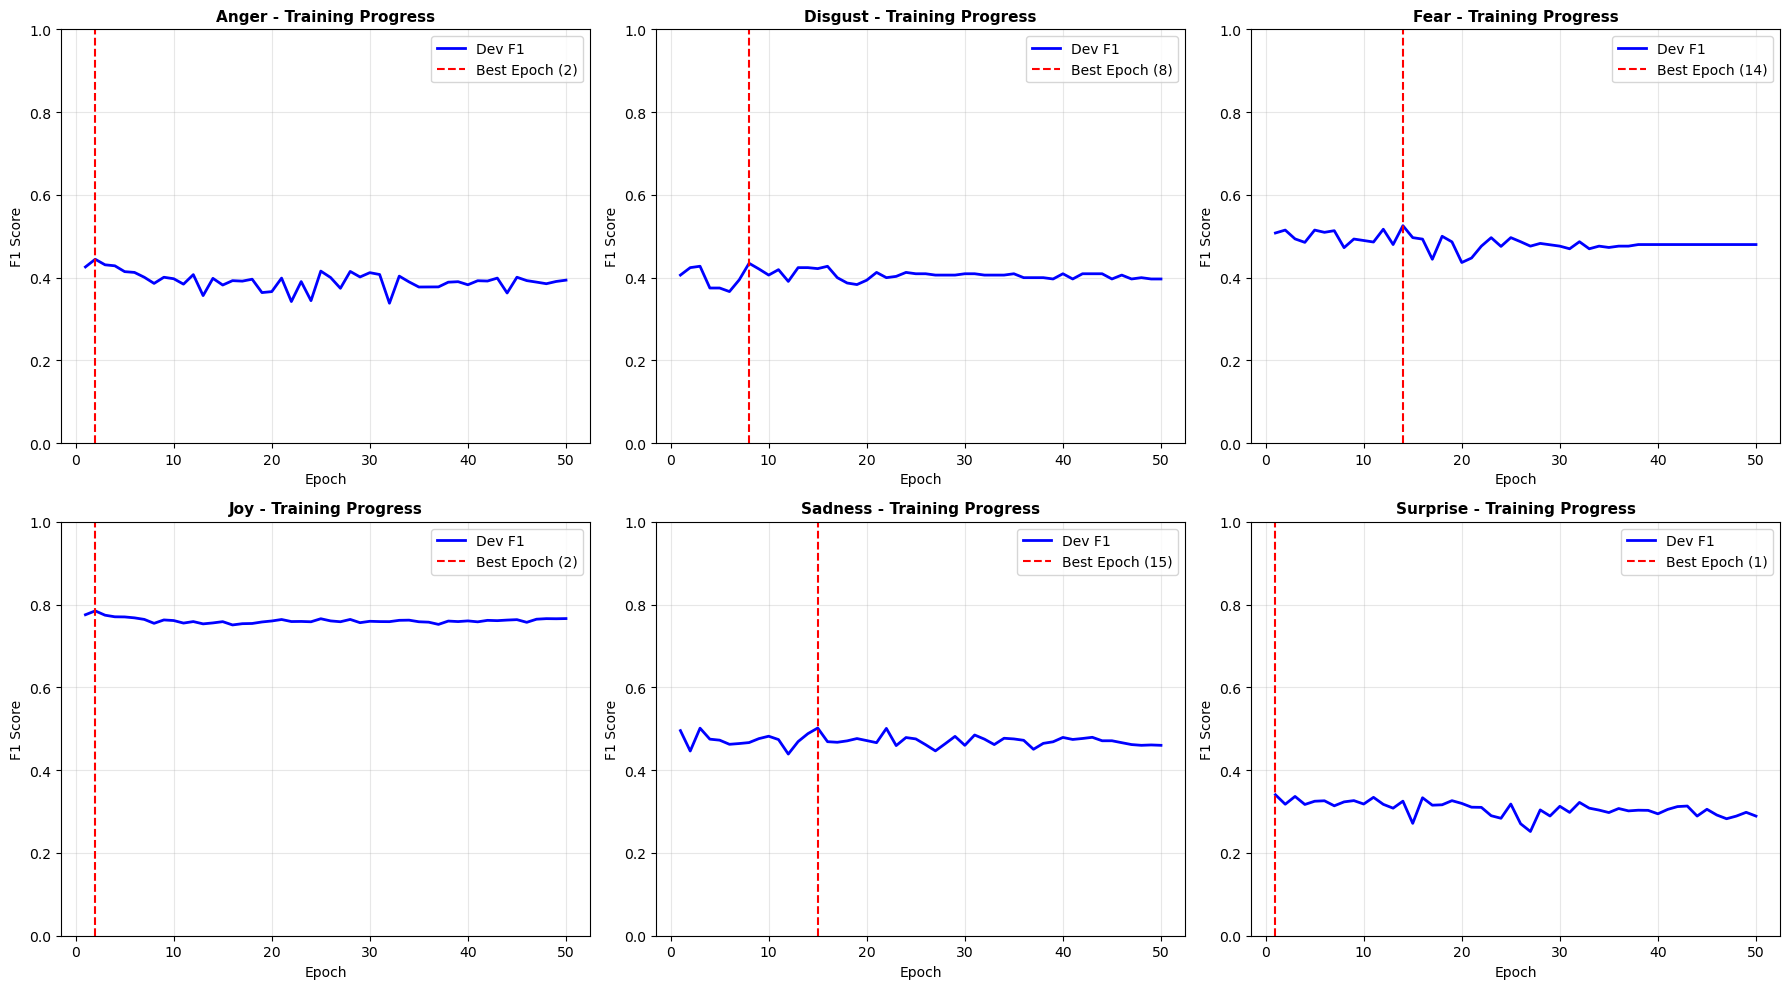

✓ Training history plot saved to results/training_history.png


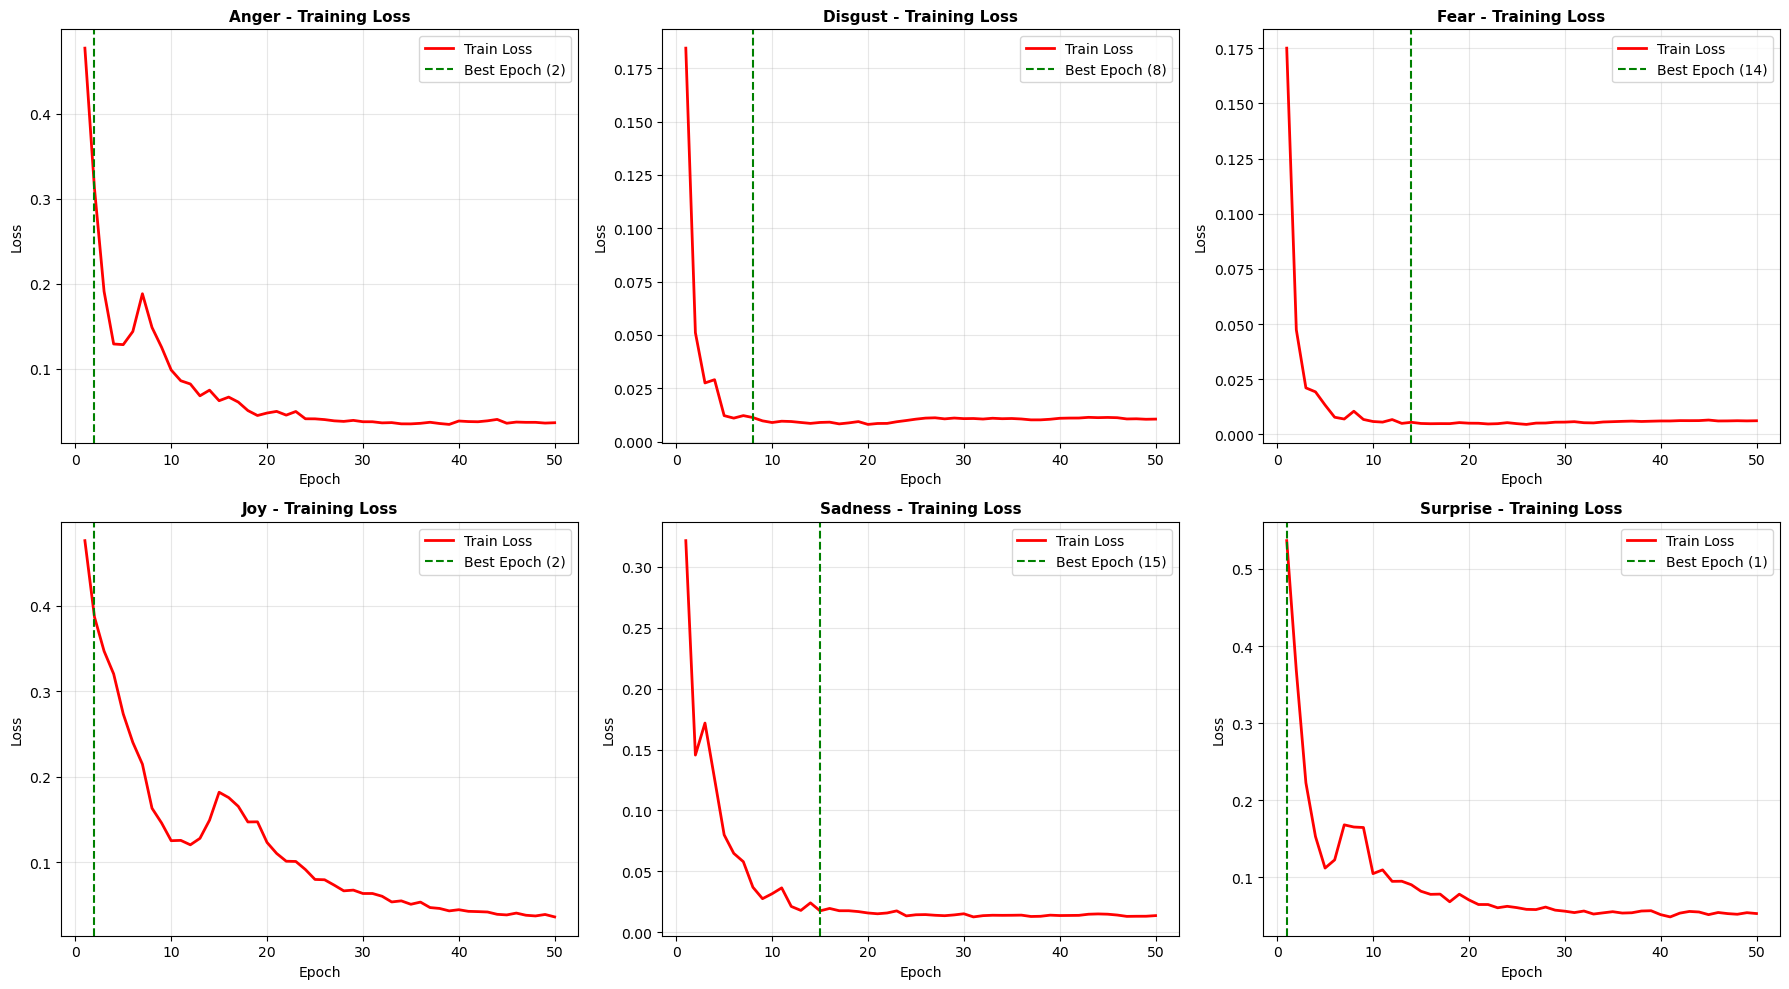

✓ Training loss plot saved to results/training_loss.png

Baseline Multi-class Training History


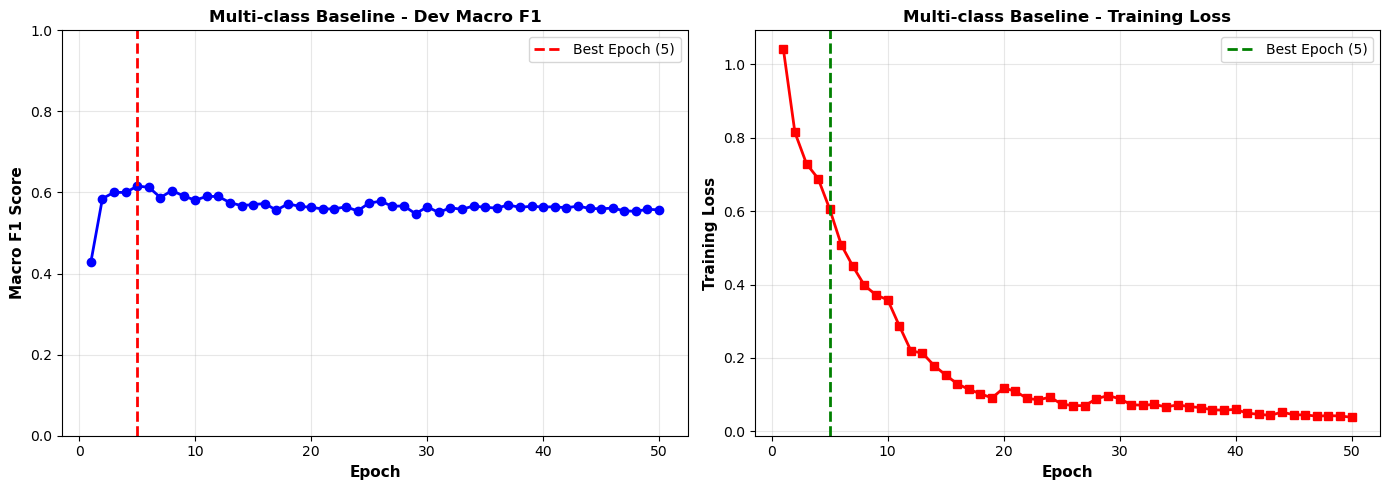

✓ Baseline history plot saved to results/baseline_history.png


In [ ]:
# Step 9: Save Results and Export Metrics
print("="*80)
print("STEP 9: EXPORTING RESULTS (WITH CLASS WEIGHTS)")
print("="*80)

# Create results directory
os.makedirs('results', exist_ok=True)

# Prepare comprehensive export data
export_data = {
    'experiment_info': {
        'date': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
        'approach': 'Class-Weighted Loss (No Resampling)',
        'class_weight_strategy': 'sklearn balanced (n_samples / (n_classes * n_samples_per_class))',
        'loss_function': 'Weighted CrossEntropyLoss',
        'model_architecture': 'BERT-base-uncased',
        'layers': 12,
        'attention_heads': 12,
        'hidden_size': 768,
        'total_parameters': '~110M',
        'fixed_hyperparameters': FIXED_PARAMS,
        'target_emotions': target_emotions,
        'dataset_sizes': {
            'train': len(train_df),
            'dev': len(dev_df),
            'test': len(test_df)
        }
    },
    
    'baseline_multiclass': {
        'test_macro_f1': float(baseline_result['test_macro_f1']),
        'dev_macro_f1': float(baseline_result['dev_macro_f1']),
        'best_epoch': int(baseline_result['best_epoch']),
        'class_weights': {k: float(v) for k, v in baseline_result['class_weights'].items()},
        'per_emotion_metrics': {
            emotion: {
                'f1': float(metrics['f1']),
                'precision': float(metrics['precision']),
                'recall': float(metrics['recall']),
                'accuracy': float(metrics['accuracy'])
            }
            for emotion, metrics in baseline_result['per_emotion_metrics'].items()
        },
        'training_history': {
            'train_loss': [float(x) for x in baseline_result['history']['train_loss']],
            'train_acc': [float(x) for x in baseline_result['history']['train_acc']],
            'dev_macro_f1': [float(x) for x in baseline_result['history']['dev_macro_f1']]
        }
    },
    
    'binary_models': {}
}

# Add binary models results using best_models_per_emotion and all_results
for emotion in target_emotions:
    best_model = best_models_per_emotion[emotion]
    result = all_results[emotion]
    
    export_data['binary_models'][emotion] = {
        'test_macro_f1': float(best_model['test_metrics']['f1']),
        'dev_macro_f1': float(best_model['dev_metrics']['f1']),
        'best_epoch': int(best_model['best_epoch']),
        'class_weights': {k: float(v) for k, v in best_model['class_weights'].items()},
        'dataset_info': {
            'train_size': int(binary_datasets[emotion]['train_size']),
            'dev_size': int(binary_datasets[emotion]['dev_size']),
            'test_size': int(binary_datasets[emotion]['test_size']),
            'original_distribution': {
                'positive': int(binary_datasets[emotion]['train_pos']),
                'negative': int(binary_datasets[emotion]['train_neg']),
                'ratio': float(binary_datasets[emotion]['imbalance_ratio'])
            }
        },
        'test_metrics': {
            'f1': float(best_model['test_metrics']['f1']),
            'precision': float(best_model['test_metrics']['precision']),
            'recall': float(best_model['test_metrics']['recall']),
            'roc_auc': float(best_model['test_metrics']['roc_auc'])
        },
        'training_history': {
            'train_loss': [float(x) for x in result['history']['train_loss']],
            'train_acc': [float(x) for x in result['history']['train_acc']],
            'dev_f1': [float(x) for x in result['history']['dev_f1']]
        }
    }

# Add comparison summary
export_data['comparison_summary'] = {
    'baseline_test_f1': float(baseline_result['test_macro_f1']),
    'average_binary_test_f1': float(comparison_df[comparison_df['Type'] == 'Binary']['Test Macro-F1'].mean()),
    'improvement': float(comparison_df[comparison_df['Type'] == 'Binary']['Test Macro-F1'].mean() - baseline_result['test_macro_f1']),
    'per_emotion_improvements': {
        emotion: float(best_models_per_emotion[emotion]['test_metrics']['f1'] - baseline_result['per_emotion_metrics'][emotion]['f1'])
        for emotion in target_emotions
    }
}

# Export to JSON
json_path = 'results/experiment_results_weighted_loss.json'
with open(json_path, 'w') as f:
    json.dump(export_data, f, indent=2)

print(f"✓ Experiment results exported to {json_path}")

# Export comparison table to CSV
csv_path = 'results/model_comparison_weighted_loss.csv'
comparison_df.to_csv(csv_path, index=False)
print(f"✓ Comparison table exported to {csv_path}")

# Create detailed per-emotion comparison CSV
per_emotion_data = []
for emotion in target_emotions:
    best_model = best_models_per_emotion[emotion]
    per_emotion_data.append({
        'Emotion': emotion.capitalize(),
        'Binary_F1': best_model['test_metrics']['f1'],
        'Binary_Precision': best_model['test_metrics']['precision'],
        'Binary_Recall': best_model['test_metrics']['recall'],
        'Binary_ROC_AUC': best_model['test_metrics']['roc_auc'],
        'Binary_Class_Weight_Positive': best_model['class_weights'][emotion],
        'Binary_Class_Weight_Negative': best_model['class_weights']['other'],
        'Baseline_F1': baseline_result['per_emotion_metrics'][emotion]['f1'],
        'Baseline_Precision': baseline_result['per_emotion_metrics'][emotion]['precision'],
        'Baseline_Recall': baseline_result['per_emotion_metrics'][emotion]['recall'],
        'Baseline_Accuracy': baseline_result['per_emotion_metrics'][emotion]['accuracy'],
        'Baseline_Class_Weight': baseline_result['class_weights'][emotion],
        'F1_Improvement': best_model['test_metrics']['f1'] - baseline_result['per_emotion_metrics'][emotion]['f1']
    })

per_emotion_df = pd.DataFrame(per_emotion_data)
per_emotion_csv = 'results/per_emotion_comparison_weighted_loss.csv'
per_emotion_df.to_csv(per_emotion_csv, index=False)
print(f"✓ Per-emotion comparison exported to {per_emotion_csv}")

# Print summary statistics
print(f"\n{'='*80}")
print("EXPORT SUMMARY")
print(f"{'='*80}")
print(f"\nFiles created:")
print(f"  1. {json_path}")
print(f"  2. {csv_path}")
print(f"  3. {per_emotion_csv}")
print(f"  4. results/comparison_weighted_loss.png")
print(f"  5. results/best_model_multiclass.pt")
for emotion in target_emotions:
    print(f"  6. results/best_model_{emotion}.pt")

print(f"\n{'='*80}")
print("CLASS WEIGHTS SUMMARY (MULTI-CLASS BASELINE)")
print(f"{'='*80}")
for emotion, weight in sorted(baseline_result['class_weights'].items(), key=lambda x: x[1], reverse=True):
    print(f"  {emotion.capitalize():<12}: {weight:.4f}")

print(f"\n{'='*80}")
print("FINAL RESULTS SUMMARY")
print(f"{'='*80}")
print(f"\nBaseline Multi-class (Weighted Loss):")
print(f"  Test Macro-F1: {baseline_result['test_macro_f1']:.4f}")
print(f"  Best Epoch: {baseline_result['best_epoch']}")

print(f"\nBinary Models (Weighted Loss):")
for emotion in target_emotions:
    best_model = best_models_per_emotion[emotion]
    print(f"  {emotion.capitalize():<12}: Test F1 = {best_model['test_metrics']['f1']:.4f}, Best Epoch = {best_model['best_epoch']}")

avg_binary_f1 = comparison_df[comparison_df['Type'] == 'Binary']['Test Macro-F1'].mean()
print(f"\nAverage Binary Test F1: {avg_binary_f1:.4f}")
print(f"Improvement over Baseline: {avg_binary_f1 - baseline_result['test_macro_f1']:+.4f}")

print(f"\n{'='*80}")
print("✓ ALL RESULTS EXPORTED SUCCESSFULLY")
print(f"{'='*80}")


In [13]:
# Step 10: Export Results to JSON
print("="*60)
print("STEP 10: EXPORT RESULTS")
print("="*60)

import json

# Compile all results for export
export_data = {
    'experiment_info': {
        'title': 'BERT Emotion Classification - Binary vs Multi-class (WITH SMOTE)',
        'dataset': 'GoEmotions (Ekman 6 emotions)',
        'architecture': 'BERT-base-uncased (12 layers, 12 heads, hidden=768)',
        'training_approach': 'Fixed hyperparameters (no tuning)',
        'data_balancing': 'SMOTE (Synthetic Minority Over-sampling Technique) with BERT embeddings',
        'preprocessing': 'Case folding, cleaning, normalization, stopword removal, stemming',
        'smote_details': {
            'method': 'SMOTE with BERT embeddings',
            'k_neighbors': 5,
            'applied_to': 'Training data only',
            'dev_test': 'Original imbalanced data (for unbiased evaluation)'
        }
    },
    'hyperparameters': {
        'learning_rate': float(FIXED_PARAMS['learning_rate']),
        'batch_size': int(FIXED_PARAMS['batch_size']),
        'epochs': int(FIXED_PARAMS['epochs']),
        'weight_decay': float(FIXED_PARAMS['weight_decay']),
        'optimizer': 'AdamW',
        'scheduler': 'Linear warmup',
        'mixed_precision': True
    },
    'binary_models': {},
    'baseline_multiclass': {}
}

# Export binary models results
for emotion in target_emotions:
    result = best_models_per_emotion[emotion]
    export_data['binary_models'][emotion] = {
        'best_epoch': int(result['best_epoch']),
        'dev_metrics': {
            'f1': float(result['dev_metrics']['f1']),
            'precision': float(result['dev_metrics']['precision']),
            'recall': float(result['dev_metrics']['recall']),
            'accuracy': float(result['dev_metrics']['accuracy']),
            'roc_auc': float(result['dev_metrics']['roc_auc'])
        },
        'test_metrics': {
            'f1': float(result['test_metrics']['f1']),
            'precision': float(result['test_metrics']['precision']),
            'recall': float(result['test_metrics']['recall']),
            'accuracy': float(result['test_metrics']['accuracy']),
            'roc_auc': float(result['test_metrics']['roc_auc'])
        }
    }

# Export baseline results
export_data['baseline_multiclass'] = {
    'best_epoch': int(baseline_result['best_epoch']),
    'dev_macro_f1': float(baseline_result['dev_macro_f1']),
    'test_macro_f1': float(baseline_result['test_macro_f1']),
    'per_emotion_test_metrics': {}
}

for emotion in target_emotions:
    export_data['baseline_multiclass']['per_emotion_test_metrics'][emotion] = {
        'f1': float(baseline_metrics[emotion]['f1']),
        'precision': float(baseline_metrics[emotion]['precision']),
        'recall': float(baseline_metrics[emotion]['recall']),
        'accuracy': float(baseline_metrics[emotion]['accuracy'])
    }

# Calculate summary statistics
binary_f1_avg = np.mean([export_data['binary_models'][e]['test_metrics']['f1'] for e in target_emotions])
baseline_f1_avg = np.mean([export_data['baseline_multiclass']['per_emotion_test_metrics'][e]['f1'] for e in target_emotions])

export_data['summary'] = {
    'binary_models_avg_f1': float(binary_f1_avg),
    'baseline_avg_f1': float(baseline_f1_avg),
    'improvement_percentage': float(((binary_f1_avg - baseline_f1_avg) / baseline_f1_avg) * 100)
}

# Save to JSON
json_path = 'results/experiment_results.json'
with open(json_path, 'w', encoding='utf-8') as f:
    json.dump(export_data, f, indent=4, ensure_ascii=False)

print(f"✓ Results exported to {json_path}")

# Display summary
print("\n" + "="*80)
print("EXPERIMENT RESULTS SUMMARY")
print("="*80)

print(f"\nHyperparameters (Fixed):")
print(f"  Learning Rate:    {FIXED_PARAMS['learning_rate']}")
print(f"  Batch Size:       {FIXED_PARAMS['batch_size']}")
print(f"  Epochs:           {FIXED_PARAMS['epochs']}")
print(f"  Weight Decay:     {FIXED_PARAMS['weight_decay']}")

print(f"\nBinary Models Results:")
for emotion in target_emotions:
    result = export_data['binary_models'][emotion]
    print(f"  {emotion.capitalize():<12}: Best Epoch={result['best_epoch']:2d}, "
          f"Test F1={result['test_metrics']['f1']:.4f}, "
          f"Precision={result['test_metrics']['precision']:.4f}, "
          f"Recall={result['test_metrics']['recall']:.4f}")

print(f"\nBaseline Multi-class Results:")
print(f"  Best Epoch: {baseline_result['best_epoch']}")
print(f"  Test Macro F1: {baseline_result['test_macro_f1']:.4f}")
for emotion in target_emotions:
    metrics = export_data['baseline_multiclass']['per_emotion_test_metrics'][emotion]
    print(f"  {emotion.capitalize():<12}: F1={metrics['f1']:.4f}, "
          f"Precision={metrics['precision']:.4f}, "
          f"Recall={metrics['recall']:.4f}")

print(f"\nOverall Comparison:")
print(f"  Binary Models Avg F1:     {binary_f1_avg:.4f}")
print(f"  Baseline Avg F1:          {baseline_f1_avg:.4f}")
print(f"  Improvement:              {export_data['summary']['improvement_percentage']:+.2f}%")

print(f"\n{'='*80}")
print("All results saved to:")
print(f"  - results/experiment_results.json")
print(f"  - results/metrics_per_emotion.csv")
print(f"  - results/comparison_plot.png")
print(f"  - results/training_history.png")
print(f"  - results/training_loss.png")
print(f"  - results/baseline_history.png")
print(f"{'='*80}")


STEP 10: EXPORT RESULTS
✓ Results exported to results/experiment_results.json

EXPERIMENT RESULTS SUMMARY

Hyperparameters (Fixed):
  Learning Rate:    2e-05
  Batch Size:       32
  Epochs:           50
  Weight Decay:     0.01

Binary Models Results:
  Anger       : Best Epoch= 1, Test F1=0.4593, Precision=0.3621, Recall=0.6277
  Disgust     : Best Epoch= 3, Test F1=0.3966, Precision=0.7188, Recall=0.2738
  Fear        : Best Epoch= 5, Test F1=0.5680, Precision=0.6000, Recall=0.5393
  Joy         : Best Epoch= 4, Test F1=0.7785, Precision=0.7660, Recall=0.7914
  Sadness     : Best Epoch= 4, Test F1=0.4894, Precision=0.4723, Recall=0.5078
  Surprise    : Best Epoch= 2, Test F1=0.3730, Precision=0.2945, Recall=0.5087

Baseline Multi-class Results:
  Best Epoch: 5
  Test Macro F1: 0.5944
  Anger       : F1=0.5637, Precision=0.4717, Recall=0.7004
  Disgust     : F1=0.4948, Precision=0.4364, Recall=0.5714
  Fear        : F1=0.6378, Precision=0.6146, Recall=0.6629
  Joy         : F1=0.8108